In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


from importlib import reload


import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 8.7*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


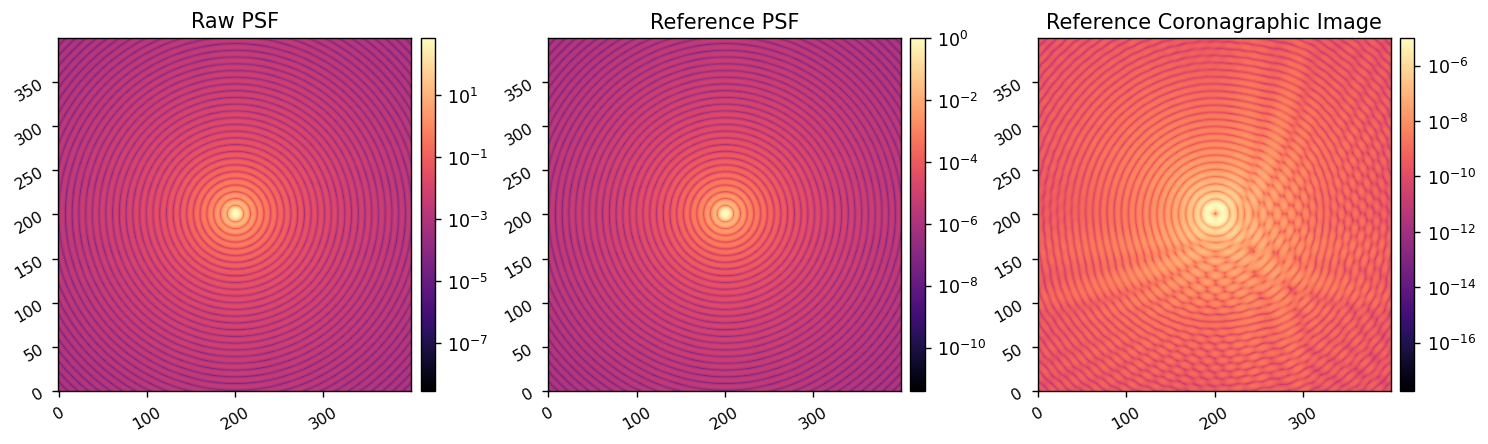

In [14]:
reload(scoob)
model = scoob.SCOOBM()

raw_psf = model.snap()
model.Imax_ref = xp.max(raw_psf)

ref_psf = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap()

imshow3(raw_psf, ref_psf, ref_im, 
        'Raw PSF', 'Reference PSF', 'Reference Coronagraphic Image',
        lognorm=True)


In [ ]:
model.calc_wfs()